In [1]:
from skimage.feature import register_translation
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from sopt.examples.utils import PtychographySimulation
from sopt.examples.tensorflow.far_field_ptychography.tfPtycho_joint_optimization import CurveballPhaseRetriever
import sopt.benchmarks.ops.tensorflow.flops_registry_custom
from tensorflow.python.framework import graph_util
from sopt.benchmarks.ops.tensorflow.graph_utils_custom import get_flops_for_sub_graph, get_flops_for_node_list

plt.rcParams.update({'font.size': 14})

W1218 18:27:24.578759 140333649782592 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/graph_utils_custom.py:14: The name tf.NodeDef is deprecated. Please use tf.compat.v1.NodeDef instead.

W1218 18:27:24.580229 140333649782592 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/graph_utils_custom.py:29: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



In [2]:
%load_ext autoreload
%autoreload 2

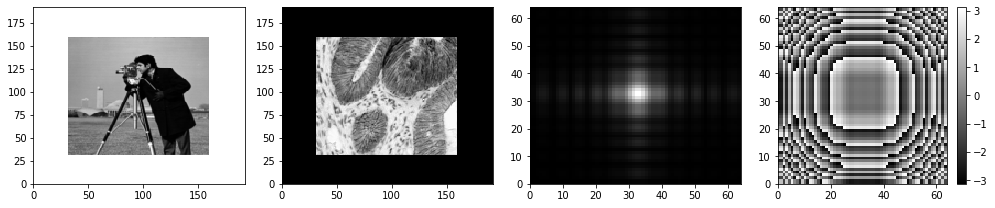

In [3]:
obj_padding_npix = 32
ptsim = PtychographySimulation(obj_npix=128, obj_padding_npix=obj_padding_npix,
                               positions_step_npix=6, probe_n_photons=1e4)

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax3)
plt.tight_layout()
plt.show()

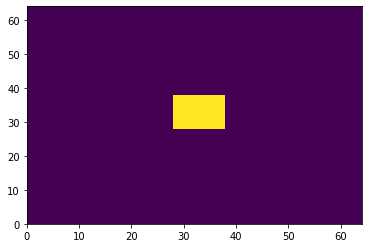

In [4]:
probe_guess = np.zeros_like(ptsim._probe_true)
probe_guess[28:38, 28:38] = 1
probe_guess = probe_guess * np.sqrt(ptsim._probe_n_photons/np.sum(np.abs(probe_guess)**2))
plt.pcolormesh(np.abs(probe_guess))
plt.show()

# Step by step analysis of the curveball model with poisson noise

In [5]:
# Full batch reconstruction

In [6]:
from sopt.examples.tensorflow.far_field_ptychography.tfPtycho_joint_optimization import CurveballPhaseRetriever, LMAPhaseRetriever

In [22]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim,  
                                probe_guess_cmplx_2d=probe_guess, 
                                validation_ndiffs=0, 
                                batch_size=100,
                                loss_type="poisson")
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [23]:
pr_cb.run(max_iters=2000, patience=200)
losses1 = pr_cb.data["loss"].rolling(10).mean().copy()

10 -456629.4 0.7503571      200        0        0
20 -553360.2 0.7082533      200        0        0
30 -550385.9 0.673494      200        0        0
40 -542240.8 0.6613942      200        0        0
50 -520561.6 0.6584873      200        0        0
60 -523438.1 0.6563454      200        0        0
70 -504857.3 0.6502809      200        0        0
80 -559905.3 0.6458554      200        0        0
90 -531233.1 0.6450408      200        0        0
100 -536453.5 0.6411443      200        0        0
110 -508659.7 0.6397455      200        0        0
120 -524169.9 0.6394272      200        0        0
130 -521851.2 0.6394221      200        0        0
140 -464974.6 0.6379087      200        0        0
150 -495337.2 0.6342524      200        0        0
160  -513034 0.6308919      200        0        0
170 -554347.9 0.6293667      200        0        0
180 -595550.9 0.6271826      200        0        0
190 -577820.2 0.6230279      200        0        0
200 -633302.6 0.6224004      200        0 

In [13]:
pr_cb.session.run(pr_cb._optparams.minimize_op)

1

In [15]:
pr_cb.run(max_iters=10)

10 -1763844 0.8485252       50        0        0



In [116]:
obj_out = pr_cb.session.run(pr_cb._tf_obj_padded_cmplx)

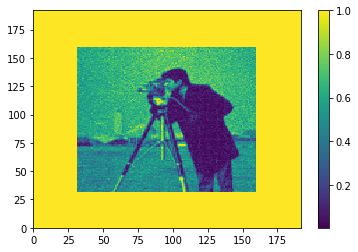

In [117]:
plt.pcolormesh(np.abs(obj_out))
plt.colorbar()

In [118]:
with pr_cb.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_cb_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_cb_and_fwd = flops_cb_and_fwd.total_float_ops
    print(f'{flops_cb_and_fwd:4.3g}')

total_flops = pr_cb.data.index[-1] * flops_cb_and_fwd
print(f'{total_flops:4.3g}')

graph_def = pr_cb.graph.as_graph_def()
# To calculate the flops required for one curveball step,
# I am isolating the nodes involved in the damping update.
# Removing this should give me the flops required per step.
# The damping update only happens every 5 steps (by default),
# so I don't want to include it in the default flops value for
# curveball.
nodes_damping = [node for node in graph_def.node if 'damping_update' in node.name]
flops_damping = get_flops_for_node_list(pr_cb.graph, nodes_damping)

nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_cb.graph, nodes_validation)
flops_validation=0

print(f'{flops_damping:4.3g}\t {flops_validation:4.3g}')
total_flops_actual = (flops_cb_and_fwd - flops_damping - flops_validation) * pr_cb.data.index[-1]
print(f'total flops {total_flops_actual:4.3g}')

/raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/flops_registry_custom.py:319: RuntimeWarning: divide by zero encountered in log2
  num_ops = np.int_(np.ceil(5 * n * np.log2(n)))
/raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/flops_registry_custom.py:319: RuntimeWarning: invalid value encountered in double_scalars
  num_ops = np.int_(np.ceil(5 * n * np.log2(n)))


2.07e+09
5.17e+11
2.63e+08	    0
total flops 4.52e+11


In [119]:
from sopt.examples.tensorflow.far_field_ptychography.tfPtycho import CurveballPhaseRetriever as CurveballPhaseRetriever2

In [120]:
pr_cb = CurveballPhaseRetriever2(ptsim=ptsim,  
                                probe_recons=True,
                                probe_guess_cmplx_2d=probe_guess, 
                                validation_ndiffs=0, 
                                batch_size=0,
                                loss_type="poisson_surrogate")
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [121]:
for i in tqdm(range(50)):
    pr_cb.run(max_iters=2000, patience=5, disable_progress_bar=True)
    pr_cb.session.run(pr_cb._obj_clip_op)
losses2 = pr_cb.data["loss"].rolling(10).mean().copy()

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7ff2a447f048>
Traceback (most recent call last):
  File "/raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/tqdm/_tqdm_notebook.py", line 228, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7ff26424d138>
Traceback (most recent call last):
  File "/raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/tqdm/_tqdm_notebook.py", line 228, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7ff26435e4f8>
Traceback (most recent call last):
  File "/raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/tqdm/_tqdm_notebook.py", line 228, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
Excepti

In [122]:
with pr_cb.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_cb_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_cb_and_fwd = flops_cb_and_fwd.total_float_ops
    print(f'{flops_cb_and_fwd:4.3g}')

total_flops = pr_cb.data.index[-1] * flops_cb_and_fwd
print(f'{total_flops:4.3g}')

graph_def = pr_cb.graph.as_graph_def()
# To calculate the flops required for one curveball step,
# I am isolating the nodes involved in the damping update.
# Removing this should give me the flops required per step.
# The damping update only happens every 5 steps (by default),
# so I don't want to include it in the default flops value for
# curveball.
nodes_damping = [node for node in graph_def.node if 'damping_update' in node.name]
flops_damping = get_flops_for_node_list(pr_cb.graph, nodes_damping)

nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_cb.graph, nodes_validation)
flops_validation=0

print(f'{flops_damping:4.3g}\t {flops_validation:4.3g}')
total_flops_actual = (flops_cb_and_fwd - flops_damping - flops_validation) * pr_cb.data.index[-1]
print(f'total flops {total_flops_actual:4.3g}')

/raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/flops_registry_custom.py:319: RuntimeWarning: divide by zero encountered in log2
  num_ops = np.int_(np.ceil(5 * n * np.log2(n)))
/raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/flops_registry_custom.py:319: RuntimeWarning: invalid value encountered in double_scalars
  num_ops = np.int_(np.ceil(5 * n * np.log2(n)))


4e+09
1e+12
5.26e+08	    0
total flops 8.68e+11


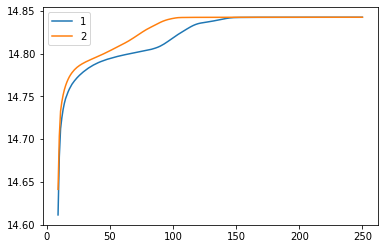

In [123]:
plt.plot(np.log(-losses1), label='1')
plt.plot(np.log(-losses2), label='2')
plt.legend(loc='best')
plt.show()

In [429]:
A_all = []
m_b_all = []
l_all = []
gamma_all = []
for i in tqdm(range(200)):
    pr_cb.run(max_iters=1, disable_progress_bar=True)
    [
        A,
        m_b,
        l,
        g
    ]= pr_cb.session.run([pr_cb._optparams.obj_optimizer._A, 
                          pr_cb._optparams.obj_optimizer._m_b,
                          pr_cb._optparams.obj_optimizer._damping_factor,
                          pr_cb._optparams.obj_optimizer._gamma_val])
    A_all.append(A)
    m_b_all.append( m_b)
    l_all.append(l)
    gamma_all.append(g)
A_all_batch = np.array(A_all)
m_b_all_batch = np.array(m_b_all)
l_all_batch = np.array(l_all)
gamma_all_batch = np.array(gamma_all)
data_batch = pr_cb.data.copy()

In [465]:
# Full batch reconstruction with surrogate

In [466]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, 
                                probe_recons=True, 
                                probe_guess_cmplx_2d=probe_guess, 
                                validation_ndiffs=25, 
                                batch_size=0,
                                loss_type="poisson_surrogate")
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [467]:
A_all = []
m_b_all = []
l_all = []
gamma_all = []
for i in tqdm(range(200)):
    pr_cb.run(max_iters=1, disable_progress_bar=True)
    [
        A,
        m_b,
        l,
        g
    ]= pr_cb.session.run([pr_cb._optparams.obj_optimizer._A, 
                          pr_cb._optparams.obj_optimizer._m_b,
                          pr_cb._optparams.obj_optimizer._damping_factor,
                          pr_cb._optparams.obj_optimizer._gamma_val])
    A_all.append(A)
    m_b_all.append( m_b)
    l_all.append(l)
    gamma_all.append(g)
A_all_batch_surr = np.array(A_all)
m_b_all_batch_surr = np.array(m_b_all)
l_all_batch_surr = np.array(l_all)
gamma_all_batch_surr = np.array(gamma_all)
data_batch_surr = pr_cb.data.copy()

In [430]:
# Minibatch reconstruction

In [431]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, 
                                probe_recons=True, 
                                #obj_guess_cmplx_2d=obj_out,
                                #probe_guess_cmplx_2d=probe_out,
                                probe_guess_cmplx_2d=probe_guess, 
                                validation_ndiffs=25, 
                                batch_size=100,
                                loss_type="poisson")
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [432]:
A_all = []
m_b_all = []
l_all = []
gamma_all = []
for i in tqdm(range(200)):
    pr_cb.run(max_iters=1, disable_progress_bar=True, manual_assign=True)
    [
        A,
        m_b,
        l,
        g
    ]= pr_cb.session.run([pr_cb._optparams.obj_optimizer._A, 
                          pr_cb._optparams.obj_optimizer._m_b,
                          pr_cb._optparams.obj_optimizer._damping_factor,
                          pr_cb._optparams.obj_optimizer._gamma_val])
    pr_cb.session.run(pr_cb._assign_op)
    A_all.append(A)
    m_b_all.append( m_b)
    l_all.append(l)
    gamma_all.append(g)
A_all_minibatch = np.array(A_all)
m_b_all_minibatch = np.array(m_b_all)
l_all_minibatch = np.array(l_all)
gamma_all_minibatch = np.array(gamma_all)
data_minibatch = pr_cb.data.copy()

In [434]:
# Minibatch with surrogate poisson loss function

In [435]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, 
                                probe_recons=True, 
                                #obj_guess_cmplx_2d=obj_out,
                                #probe_guess_cmplx_2d=probe_out,
                                probe_guess_cmplx_2d=probe_guess, 
                                validation_ndiffs=25, 
                                batch_size=100,
                                loss_type="poisson_surrogate")
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [436]:
A_all = []
m_b_all = []
l_all = []
gamma_all = []
for i in tqdm(range(200)):
    pr_cb.run(max_iters=1, disable_progress_bar=True, manual_assign=True)
    [
        A,
        m_b,
        l,
        g
    ]= pr_cb.session.run([pr_cb._optparams.obj_optimizer._A, 
                          pr_cb._optparams.obj_optimizer._m_b,
                          pr_cb._optparams.obj_optimizer._damping_factor,
                          pr_cb._optparams.obj_optimizer._gamma_val])
    _ = pr_cb.session.run(pr_cb._assign_op)
    A_all.append(A)
    m_b_all.append( m_b)
    l_all.append(l)
    gamma_all.append(g)
A_all_minibatch_surr = np.array(A_all)
m_b_all_minibatch_surr = np.array(m_b_all)
l_all_minibatch_surr = np.array(l_all)
gamma_all_minibatch_surr = np.array(gamma_all)
data_minibatch_surr = pr_cb.data.copy()

In [438]:
# Minibatch with amplitude loss function

In [439]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, 
                                probe_recons=True, 
                                #obj_guess_cmplx_2d=obj_out,
                                #probe_guess_cmplx_2d=probe_out,
                                probe_guess_cmplx_2d=probe_guess, 
                                validation_ndiffs=25, 
                                batch_size=100)
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [440]:
A_all = []
m_b_all = []
l_all = []
gamma_all = []
for i in tqdm(range(200)):
    pr_cb.run(max_iters=1, disable_progress_bar=True, manual_assign=True)
    [
        A,
        m_b,
        l,
        g
    ]= pr_cb.session.run([pr_cb._optparams.obj_optimizer._A, 
                          pr_cb._optparams.obj_optimizer._m_b,
                          pr_cb._optparams.obj_optimizer._damping_factor,
                          pr_cb._optparams.obj_optimizer._gamma_val])
    _ = pr_cb.session.run(pr_cb._assign_op)
    A_all.append(A)
    m_b_all.append( m_b)
    l_all.append(l)
    gamma_all.append(g)
A_all_minibatch_gauss = np.array(A_all)
m_b_all_minibatch_gauss = np.array(m_b_all)
l_all_minibatch_gauss = np.array(l_all)
gamma_all_minibatch_gauss = np.array(gamma_all)
data_minibatch_gauss = pr_cb.data.copy()

In [441]:
# Minibatch poisson with initial structure obtained from previous optimization

In [442]:
npix = pr_cb._ptsim._obj_padding_npix
obj_out = pr_cb.session.run(pr_cb._tf_obj_padded_cmplx)[npix:-npix, npix:-npix]
probe_out = pr_cb.session.run(pr_cb._tf_probe_cmplx)

In [444]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, 
                                probe_recons=True, 
                                obj_guess_cmplx_2d=obj_out,
                                probe_guess_cmplx_2d=probe_out,
                                validation_ndiffs=25, 
                                batch_size=100,
                                loss_type="poisson")
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [445]:
A_all = []
m_b_all = []
l_all = []
gamma_all = []
for i in tqdm(range(200)):
    pr_cb.run(max_iters=1, disable_progress_bar=True, manual_assign=True)
    [
        A,
        m_b,
        l,
        g
    ]= pr_cb.session.run([pr_cb._optparams.obj_optimizer._A, 
                          pr_cb._optparams.obj_optimizer._m_b,
                          pr_cb._optparams.obj_optimizer._damping_factor,
                          pr_cb._optparams.obj_optimizer._gamma_val])
    _ = pr_cb.session.run(pr_cb._assign_op)
    A_all.append(A)
    m_b_all.append( m_b)
    l_all.append(l)
    gamma_all.append(g)
A_all_minibatch_2 = np.array(A_all)
m_b_all_minibatch_2 = np.array(m_b_all)
l_all_minibatch_2 = np.array(l_all)
gamma_all_minibatch_2 = np.array(gamma_all)
data_minibatch_2 = pr_cb.data.copy()

Text(0.5, 0, 'Steps')

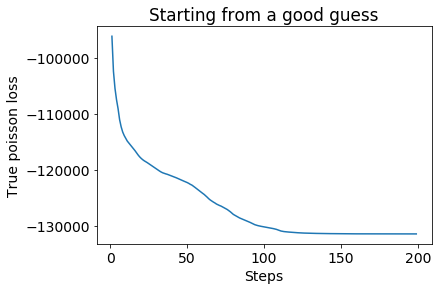

In [501]:
plt.plot(pr_cb.data['validation_loss'])
plt.ylabel("True poisson loss")
plt.title("Starting from a good guess")
plt.xlabel("Steps")

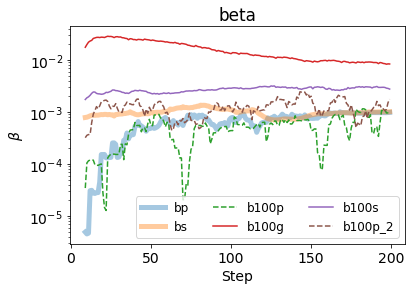

In [495]:
# Plotting the beta values
movavb = lambda m_b: pd.Series(m_b[:,0]).rolling(10).mean()

plt.plot(movavb(m_b_all_batch), label='bp', linewidth=5.0, alpha=0.4)
plt.plot(movavb(m_b_all_batch_surr), label='bs', linewidth=5.0, alpha=0.4)
plt.plot(movavb(m_b_all_minibatch), label='b100p', ls='--')
plt.plot(movavb(m_b_all_minibatch_gauss), label='b100g')
plt.plot(movavb(m_b_all_minibatch_surr), label='b100s')
plt.plot(movavb(m_b_all_minibatch_2), label='b100p_2', ls='--')
plt.title('beta')
plt.ylabel(r'$\beta$')
plt.xlabel('Step')
plt.yscale('log')
plt.legend(loc='best', ncol=3, fontsize=12)
plt.show()

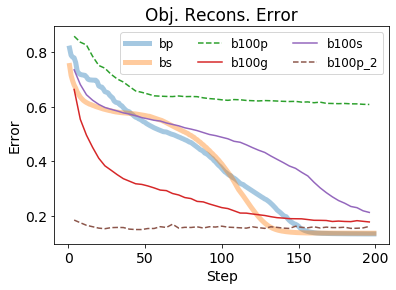

In [494]:
plt.plot(data_batch["obj_error"].dropna(), label='bp', linewidth=5.0, alpha=0.4)
plt.plot(data_batch_surr["obj_error"].dropna(), label='bs', linewidth=5.0, alpha=0.4)
plt.plot(data_minibatch["obj_error"].dropna(), label='b100p', ls='--')
plt.plot(data_minibatch_gauss["obj_error"].dropna(), label='b100g')
plt.plot(data_minibatch_surr["obj_error"].dropna(), label='b100s')
plt.plot(data_minibatch_2["obj_error"].dropna(), label='b100p_2', ls='--')
plt.title('Obj. Recons. Error')
plt.ylabel('Error')
plt.xlabel('Step')
plt.legend(loc='best', ncol=3, fontsize=12)
plt.show()

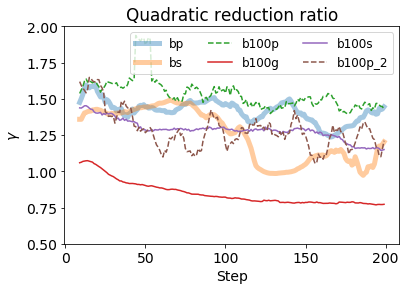

In [496]:
movavg = lambda g: pd.Series(g).rolling(10).mean()

plt.plot(movavg(gamma_all_batch), label='bp', linewidth=5.0, alpha=0.4)
plt.plot(movavg(gamma_all_batch_surr), label='bs', linewidth=5.0, alpha=0.4)
plt.plot(movavg(gamma_all_minibatch), label='b100p', ls='--')
plt.plot(movavg(gamma_all_minibatch_gauss), label='b100g')
plt.plot(movavg(gamma_all_minibatch_surr), label='b100s')
plt.plot(movavg(gamma_all_minibatch_2), label='b100p_2', ls='--')
plt.ylim([0.5,2])
plt.title('Quadratic reduction ratio')
plt.ylabel(r'$\gamma$')
plt.xlabel('Step')
plt.legend(loc='best', ncol=3, fontsize=12)
plt.show()

In [263]:
# Minibatch poisson - regularized hessian

In [278]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, 
                                probe_recons=True,
                                probe_guess_cmplx_2d=probe_guess,
                                validation_ndiffs=25, 
                                batch_size=10,
                                loss_type="poisson")
pr_cb.setOptimizingParams()#damping_update_factor_obj=0.9,
                          #damping_update_factor_probe=0.9,
                          #damping_update_frequency_obj=5,
                          #damping_update_frequency_probe=5,
                          #update_cond_threshold_low=0.5,
                          #update_cond_threshold_high=1.5)
pr_cb.initSession()

In [283]:
hmax_all = []
damping_all = []
for i in tqdm(range(1000)):
    pr_cb.run(max_iters=1, disable_progress_bar=True, manual_assign=True)
    [
        damping
    ]= pr_cb.session.run([pr_cb._optparams.obj_optimizer._damping_factor])
    _ = pr_cb.session.run(pr_cb._assign_op)
    damping_all.append(damping)
damping_all = np.array(damping_all)

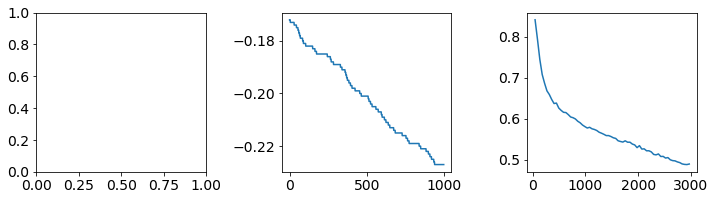

In [284]:
fig, axs = plt.subplots(1, 3, figsize=[10,3])
#axs[0].plot(np.log(hmax_all))
axs[1].plot(np.log(damping_all))
axs[2].plot(pr_cb.data["obj_error"].dropna())
plt.tight_layout()

## Curveball - reconstructing both object and probe

In [340]:
npix = pr_cb._ptsim._obj_padding_npix
obj_out = pr_cb.session.run(pr_cb._tf_obj_padded_cmplx)[npix:-npix, npix:-npix]
probe_out = pr_cb.session.run(pr_cb._tf_probe_cmplx)

In [341]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, 
                                probe_recons=True, 
                                obj_guess_cmplx_2d=obj_out,
                                probe_guess_cmplx_2d=probe_out,
                                #probe_guess_cmplx_2d=probe_guess, 
                                validation_ndiffs=25, 
                                batch_size=50,
                                poisson_loss=True)
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [342]:
A_all = []
m_b_all = []
l_all = []
gamma_all = []
for i in tqdm(range(500)):
    pr_cb.run(max_iters=1, disable_progress_bar=True)
    [
        A,
        m_b,
        l,
        g
    ]= pr_cb.session.run([pr_cb._optparams.obj_optimizer._A, 
                          pr_cb._optparams.obj_optimizer._m_b,
                          pr_cb._optparams.obj_optimizer._damping_factor,
                          pr_cb._optparams.obj_optimizer._gamma_val])
    A_all.append(A)
    m_b_all.append( m_b)
    l_all.append( l)
    gamma_all.append(g)
A_all = np.array(A_all)
m_b_all = np.array(m_b_all)
l_all = np.array(l_all)
gamma_all = np.array(gamma_all)

In [343]:
A_minibatch_all_new = A_all.copy()
m_b_minibatch_all_new = m_b_all.copy()
loss_minibatch_all_new = pr_cb.data["loss"].copy()

In [344]:
beta_minibatch = pd.Series(np.array(m_b_minibatch_all)[:,0])
beta_minibatch_new = pd.Series(m_b_minibatch_all_new[:,0])
beta_batch = pd.Series(np.array(m_b_batch_all)[:,0])
beta_batch_new = pd.Series(np.array(m_b_batch_all_new)[:,0])

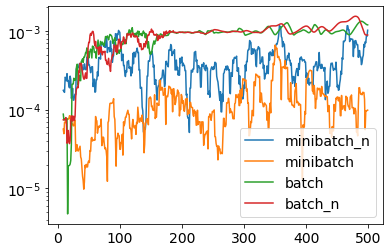

In [345]:
plt.plot(beta_minibatch_new.rolling(10).mean(), label='minibatch_n')
plt.plot(beta_minibatch.rolling(10).mean(), label='minibatch')
plt.plot(beta_batch.rolling(10).mean(), label='batch')
plt.plot(beta_batch_new.rolling(10).mean(), label='batch_n')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

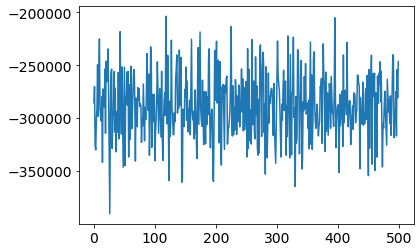

In [346]:
plt.plot(pr_cb.data["loss"])

In [347]:
#pr_cb.run(probe_fixed_epochs=0, max_iters=500)
pr_cb.data.tail(n=1)

,loss,epoch,obj_error,probe_error,validation_loss,patience
499,-246484.59375,55.0,NaN,NaN,NaN,NaN


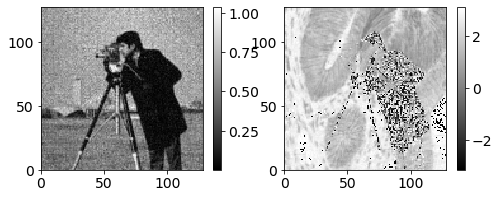

In [348]:
pr_cb.genPlotsRecons()

/raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


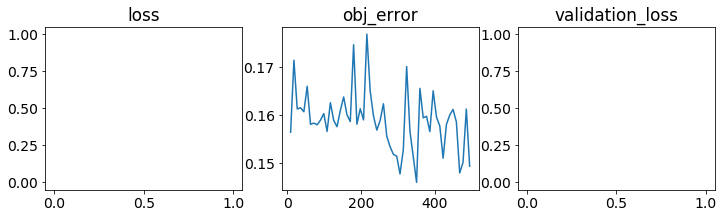

In [349]:
pr_cb.genPlotMetrics()

In [18]:
with pr_cb.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_cb_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_cb_and_fwd = flops_cb_and_fwd.total_float_ops
    print(f'{flops_cb_and_fwd:4.3g}')

total_flops = pr_cb.data.index[-1] * flops_cb_and_fwd
print(f'{total_flops:4.3g}')

graph_def = pr_cb.graph.as_graph_def()
# To calculate the flops required for one curveball step,
# I am isolating the nodes involved in the damping update.
# Removing this should give me the flops required per step.
# The damping update only happens every 5 steps (by default),
# so I don't want to include it in the default flops value for
# curveball.
nodes_damping = [node for node in graph_def.node if 'damping_update' in node.name]
flops_damping = get_flops_for_node_list(pr_cb.graph, nodes_damping)

nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_cb.graph, nodes_validation)

print(f'{flops_damping:4.3g}\t {flops_validation:4.3g}')
total_flops_actual = (flops_cb_and_fwd - flops_damping - flops_validation) * pr_cb.data.index[-1]
print(f'total flops {total_flops_actual:4.3g}')

3.6e+09
7.97e+11
4.65e+08	 2.36e+07
total flops 6.89e+11


## Batch size 100 

In [19]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, 
                                probe_recons=True,
                                probe_guess_cmplx_2d=probe_guess,
                                batch_size=100,
                                validation_ndiffs=50,
                                poisson_loss=True)
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [20]:
pr_cb.run(probe_fixed_epochs=5, max_iters=3000)
pr_cb.data.tail(n=1)

10 -517324.5 0.6346347       50 -261848.7 -259278.8
20 -633795.4 0.5749979       50 -271018.7 -270169.4
30  -454649 0.5402278       50 -274582.7 -274315.6
40 -512786.8 0.5046277       60 -277156.5 -276939.1
50 -556338.8 0.4544057     73.5 -280669.4 -280826.5
60 -463033.1 0.3839019       90 -286264.2 -285710.6
70 -663352.1 0.3231192      105 -289234.7 -288913.4
80  -551763 0.2277191      120 -294325.9 -293793.2
90 -558686.8 0.1930255      135 -295416.1 -295368.4
100 -548277.5 0.1643692      147 -296113.8 -296140.9
110 -633396.6 0.1439819    160.5 -297187.6 -297263.8
120 -502809.2 0.1438444    160.5 -297038.7 -297263.8
130 -579036.1 0.139628    187.5 -297105.9 -297272.2
140 -544766.9 0.1486128    187.5 -296602.2 -297272.2
150  -557238 0.1406335    187.5 -297130.3 -297272.2
160  -543184 0.1458886    187.5 -296794.8 -297272.2
170 -608551.2 0.1399694    187.5 -297124.1 -297272.2
180 -549208.2 0.1394134    187.5 -297132.6 -297272.2


,loss,epoch,obj_error,probe_error,validation_loss,patience
752,-626635.5,188.0,0.139985,NaN,-297199.625,187.5


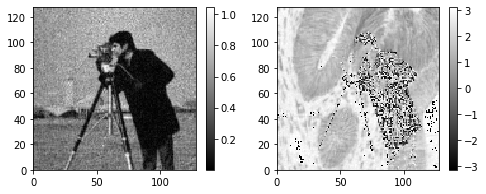

/raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


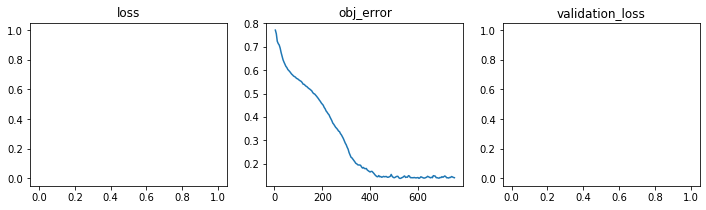

In [21]:
pr_cb.genPlotsRecons()
pr_cb.genPlotMetrics()

In [22]:
with pr_cb.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_cb_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_cb_and_fwd = flops_cb_and_fwd.total_float_ops
    print(f'{flops_cb_and_fwd:4.3g}')

total_flops = pr_cb.data.index[-1] * flops_cb_and_fwd
print(f'{total_flops:4.3g}')

graph_def = pr_cb.graph.as_graph_def()
# To calculate the flops required for one curveball step,
# I am isolating the nodes involved in the damping update.
# Removing this should give me the flops required per step.
# The damping update only happens every 5 steps (by default),
# so I don't want to include it in the default flops value for
# curveball.
nodes_damping = [node for node in graph_def.node if 'damping_update' in node.name]
flops_damping = get_flops_for_node_list(pr_cb.graph, nodes_damping)

nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_cb.graph, nodes_validation)

print(f'{flops_damping:4.3g}\t {flops_validation:4.3g}')
total_flops_actual = (flops_cb_and_fwd - flops_damping - flops_validation) * pr_cb.data.index[-1]
print(f'total flops {total_flops_actual:4.3g}')

7.97e+08
5.99e+11
9.85e+07	 2.36e+07
total flops 5.08e+11
